In [1]:
pip install -q pandas numpy scikit-learn xgboost shap seaborn matplotlib

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, roc_auc_score, confusion_matrix, classification_report

In [2]:
import pandas as pd

# 1.1  Load
df = pd.read_csv('Final_Marks_Data.csv')

# 1.2  Quick sanity checks
print('Shape :', df.shape)
print('\nHead:')
print(df.head())
print('\nInfo:')
print(df.info())

Shape : (2000, 7)

Head:
  Student_ID  Attendance (%)  Internal Test 1 (out of 40)  \
0      S1000              84                           30   
1      S1001              91                           24   
2      S1002              73                           29   
3      S1003              80                           36   
4      S1004              84                           31   

   Internal Test 2 (out of 40)  Assignment Score (out of 10)  \
0                           36                             7   
1                           38                             6   
2                           26                             7   
3                           35                             7   
4                           37                             8   

   Daily Study Hours  Final Exam Marks (out of 100)  
0                  3                             72  
1                  3                             56  
2                  3                             56  
3      

In [4]:
df['Internal_Total'] = (df['Internal Test 1 (out of 40)'] +
                        df['Internal Test 2 (out of 40)'])
df['Internal_Avg']   = df['Internal_Total'] / 2        # 0-40 scale
df['Assignment_pct'] = df['Assignment Score (out of 10)'] * 10  # 0-100
df['Attendance_bin'] = (df['Attendance (%)'] < 70).astype(int)  # domain flag


In [5]:
df['RiskLabel'] = (df['Final Exam Marks (out of 100)'] < 45).astype(int)

print('Risk prevalence:', df['RiskLabel'].mean().round(3))
print(df[['Student_ID','Internal_Avg','Attendance (%)','RiskLabel']].head())

Risk prevalence: 0.042
  Student_ID  Internal_Avg  Attendance (%)  RiskLabel
0      S1000          33.0              84          0
1      S1001          31.0              91          0
2      S1002          27.5              73          0
3      S1003          35.5              80          0
4      S1004          34.0              84          0


In [8]:
X = df[['Attendance (%)', 'Internal_Avg', 'Assignment_pct',
        'Daily Study Hours', 'Attendance_bin']].copy()
y = df['RiskLabel']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

print('Train risk rate:', y_train.mean().round(3))
print('Test  risk rate:', y_test.mean().round(3))

Train risk rate: 0.041
Test  risk rate: 0.042


In [9]:
print(df['RiskLabel'].value_counts())
print('\nImbalance ratio (majority:minority) =',
      (y == 0).sum() / (y == 1).sum())

RiskLabel
0    1917
1      83
Name: count, dtype: int64

Imbalance ratio (majority:minority) = 23.096385542168676


In [10]:
X = df[['Attendance (%)', 'Internal_Avg', 'Assignment_pct',
        'Daily Study Hours', 'Attendance_bin']].copy()
y = df['RiskLabel']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

print('Train shape:', X_train.shape,
      '  Train risk rate:', y_train.mean().round(3))
print('Test  shape:', X_test.shape,
      '  Test  risk rate:', y_test.mean().round(3))

Train shape: (1600, 5)   Train risk rate: 0.041
Test  shape: (400, 5)   Test  risk rate: 0.042


In [12]:
# 4.1  Fit model
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [13]:
y_pred_lr   = log_reg.predict(X_test)
y_prob_lr   = log_reg.predict_proba(X_test)[:, 1]

In [15]:
print('Logistic Regression (test)')
print('Recall   :', round(recall_score(y_test, y_pred_lr), 3))
print('ROC-AUC  :', round(roc_auc_score(y_test, y_prob_lr), 3))
print('\nConfusion matrix:')
print(confusion_matrix(y_test, y_pred_lr))

Logistic Regression (test)
Recall   : 0.882
ROC-AUC  : 0.969

Confusion matrix:
[[353  30]
 [  2  15]]


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, roc_auc_score

In [17]:
rf = RandomForestClassifier(
        n_estimators=400,
        max_depth=6,
        class_weight='balanced',
        random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

In [19]:
print('Random Forest (test)')
print('Recall   :', round(recall_score(y_test, y_pred_rf), 3))
print('ROC-AUC  :', round(roc_auc_score(y_test, y_prob_rf), 3))
print('\nConfusion matrix:')
print(confusion_matrix(y_test, y_pred_rf))

Random Forest (test)
Recall   : 0.765
ROC-AUC  : 0.961

Confusion matrix:
[[364  19]
 [  4  13]]


In [21]:
import xgboost as xgb
import shap

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest  = xgb.DMatrix(X_test,  label=y_test)

ratio = (y_train == 0).sum() / (y_train == 1).sum()
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'scale_pos_weight': ratio,
    'max_depth': 4,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

model = xgb.train(params,
                  dtrain,
                  num_boost_round=1000,
                  evals=[(dtest, 'eval')],
                  verbose_eval=False,
                  early_stopping_rounds=50)
y_prob_xgb = model.predict(dtest)
y_pred_xgb = (y_prob_xgb >= 0.5).astype(int)
print('XGBoost (test)')
print('Recall   :', round(recall_score(y_test, y_pred_xgb), 3))
print('ROC-AUC  :', round(roc_auc_score(y_test, y_prob_xgb), 3))
print('\nConfusion matrix:')
print(confusion_matrix(y_test, y_pred_xgb))

XGBoost (test)
Recall   : 0.765
ROC-AUC  : 0.962

Confusion matrix:
[[362  21]
 [  4  13]]


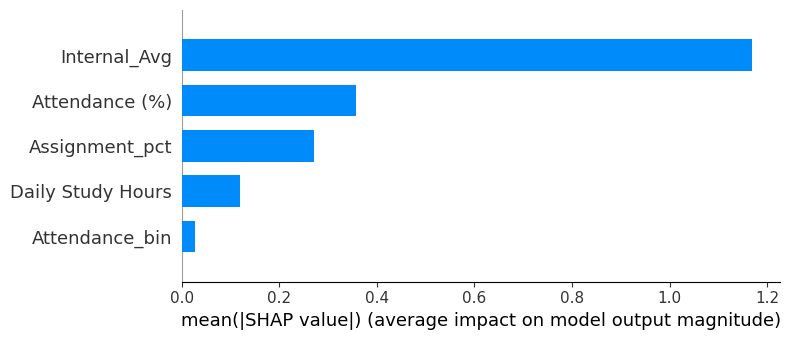

In [23]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type="bar")

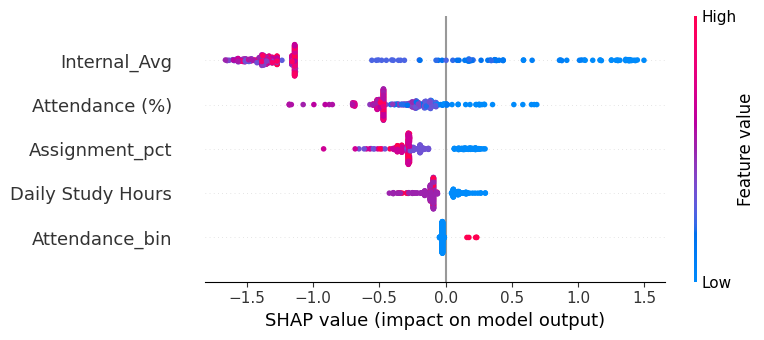

In [24]:
shap.summary_plot(shap_values, X_test)

In [25]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresh = precision_recall_curve(y_test, y_prob_xgb)

# Find lowest threshold with Recall >= 0.85
recall_85_idx = np.where(recall >= 0.85)[0][-1]   # last index that satisfies
thresh_85 = thresh[recall_85_idx]
print(f'Threshold for Recall ≥ 0.85: {thresh_85:.3f}')
print(f'Precision at that threshold: {precision[recall_85_idx]:.3f}')
print(f'Recall     at that threshold: {recall[recall_85_idx]:.3f}')

#  Applying new threshold
y_pred_85 = (y_prob_xgb >= thresh_85).astype(int)
print('\nAdjusted confusion matrix:')
print(confusion_matrix(y_test, y_pred_85))

Threshold for Recall ≥ 0.85: 0.407
Precision at that threshold: 0.349
Recall     at that threshold: 0.882

Adjusted confusion matrix:
[[355  28]
 [  2  15]]


In [26]:
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
recall_list, auc_list = [], []

for fold, (idx_tr, idx_val) in enumerate(cv.split(X, y), 1):
    X_tr, X_val = X.iloc[idx_tr], X.iloc[idx_val]
    y_tr, y_val = y.iloc[idx_tr], y.iloc[idx_val]

    # train XGBoost
    dtr   = xgb.DMatrix(X_tr, label=y_tr)
    dval  = xgb.DMatrix(X_val, label=y_val)
    clf   = xgb.train(params, dtr, num_boost_round=1000,
                      evals=[(dval, 'eval')], verbose_eval=False,
                      early_stopping_rounds=50)

    # predict
    prob_val = clf.predict(dval)
    pred_val = (prob_val >= 0.407).astype(int)  # fixed threshold from STEP 8

    recall_list.append(recall_score(y_val, pred_val))
    auc_list.append(roc_auc_score(y_val, prob_val))

print('5-fold CV results (threshold = 0.407)')
print('Mean Recall   :', np.round(np.mean(recall_list), 3),
      '±', np.round(np.std(recall_list), 3))
print('Mean ROC-AUC  :', np.round(np.mean(auc_list), 3),
      '±', np.round(np.std(auc_list), 3))

5-fold CV results (threshold = 0.407)
Mean Recall   : 0.882 ± 0.123
Mean ROC-AUC  : 0.976 ± 0.01


In [28]:
# Logistic odds ratios
lr_coef = pd.Series(log_reg.coef_[0], index=X.columns)
odds_ratio = np.exp(lr_coef)

In [29]:
shap_abs_mean = pd.Series(np.abs(shap_values).mean(axis=0), index=X.columns)


In [30]:
import_tbl = pd.DataFrame({
    'Odds_Ratio_LR': odds_ratio,
    'MeanAbsSHAP_XGB': shap_abs_mean
}).round(2)
import_tbl = import_tbl.sort_values('MeanAbsSHAP_XGB', ascending=False)
print(import_tbl)

                   Odds_Ratio_LR  MeanAbsSHAP_XGB
Internal_Avg                0.49             1.17
Attendance (%)              0.82             0.36
Assignment_pct              0.88             0.27
Daily Study Hours           0.29             0.12
Attendance_bin              0.97             0.03


In [33]:
def risk_query(attendance, internal_1, internal_2, assignment, study_hours,
               threshold=0.407):
    """
    Returns risk probability, label, and expected final mark.
    Expected mark uses a simple linear regression fitted earlier (optional).
    """
    # build feature vector
    internal_avg = (internal_1 + internal_2) / 2
    assign_pct   = assignment * 10
    att_bin      = int(attendance < 70)
    X_vec = pd.DataFrame([[attendance, internal_avg, assign_pct,
                       study_hours, att_bin]], columns=X.columns)

    # risk probability
    dvec = xgb.DMatrix(X_vec)
    prob = float(model.predict(dvec)[0]) # Explicitly extract the scalar value
    label = 'HIGH' if prob >= threshold else 'LOW'

    # crude expected mark (demo only)
    expected_mark = max(0, min(100,
                               45 + 1.2*(internal_avg-20) + 0.3*(attendance-70) + 5*study_hours))

    return {'risk_probability': round(prob,3),
            'risk_label': label,
            'expected_final_mark': int(expected_mark)}

# ex call
risk_query(attendance=68, internal_1=22, internal_2=19,
           assignment=6, study_hours=1.5)

{'risk_probability': 0.981, 'risk_label': 'HIGH', 'expected_final_mark': 52}

In [34]:
import json, joblib
model.save_model('early_warning_xgb.json')
meta = {'threshold': 0.407,
        'features': list(X.columns)}
with open('early_warning_meta.json', 'w') as f:
    json.dump(meta, f, indent=2)

print('Files saved: early_warning_xgb.json  &  early_warning_meta.json')

Files saved: early_warning_xgb.json  &  early_warning_meta.json


In [35]:
# Testing
import xgboost as xgb
import json
import numpy as np

# 1.  Load artefacts once
model = xgb.Booster()
model.load_model('early_warning_xgb.json')
with open('early_warning_meta.json') as f:
    meta = json.load(f)
THRESH = meta['threshold']
FEATURES = meta['features']

def risk_query(attendance, internal_1, internal_2, assignment, study_hours):
    internal_avg = (internal_1 + internal_2) / 2
    assign_pct   = assignment * 10
    att_bin      = int(attendance < 70)
    X_vec = np.array([[attendance, internal_avg, assign_pct, study_hours, att_bin]])
    dvec  = xgb.DMatrix(X_vec, feature_names=FEATURES)
    prob  = float(model.predict(dvec))
    label = 'HIGH' if prob >= THRESH else 'LOW'
    # crude mark estimate (same regression idea)
    mark  = 45 + 1.2*(internal_avg-20) + 0.3*(attendance-70) + 5*study_hours
    mark  = int(np.clip(mark, 0, 100))
    return {'risk_probability': round(prob,3),
            'risk_label': label,
            'expected_final_mark': mark}



In [36]:
#examples
examples = [
    {"attendance": 68, "internal_1": 22, "internal_2": 19, "assignment": 6, "study_hours": 1.5},   # weak student
    {"attendance": 95, "internal_1": 38, "internal_2": 37, "assignment": 9, "study_hours": 4.0}    # strong student
]

for i, ex in enumerate(examples, 1):
    print(f'\nStudent {i}:', ex)
    print('→', risk_query(**ex))


Student 1: {'attendance': 68, 'internal_1': 22, 'internal_2': 19, 'assignment': 6, 'study_hours': 1.5}
→ {'risk_probability': 0.981, 'risk_label': 'HIGH', 'expected_final_mark': 52}

Student 2: {'attendance': 95, 'internal_1': 38, 'internal_2': 37, 'assignment': 9, 'study_hours': 4.0}
→ {'risk_probability': 0.01, 'risk_label': 'LOW', 'expected_final_mark': 93}


/tmp/ipython-input-2487097462.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob  = float(model.predict(dvec))


In [37]:
def generate_feedback(risk_dict):
    prob = risk_dict['risk_probability']
    label = risk_dict['risk_label']
    mark = risk_dict['expected_final_mark']
    if label == 'HIGH':
        return (f"The model estimates a {prob*100:.1f} % probability of academic failure. "
                f"The student is currently on track for a final mark around {mark}, "
                f"which sits below the 45 % concern threshold. "
                f"Early intervention (study-skills workshop / advisor meeting) is recommended.")
    else:
        return (f"The model estimates a low risk of failure ({prob*100:.1f} %). "
                f"With continued engagement the student is projected to achieve ≈ {mark} %, "
                f"well above the academic-concern line.")

In [39]:
for i, ex in enumerate(examples, 1):
    res = risk_query(**ex)
    print(f'\nStudent {i}')
    print(generate_feedback(res))


Student 1
The model estimates a 98.1 % probability of academic failure. The student is currently on track for a final mark around 52, which sits below the 45 % concern threshold. Early intervention (study-skills workshop / advisor meeting) is recommended.

Student 2
The model estimates a low risk of failure (1.0 %). With continued engagement the student is projected to achieve ≈ 93 %, well above the academic-concern line.


/tmp/ipython-input-2487097462.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prob  = float(model.predict(dvec))
